# Showered Events

## 1. Software: `Pythia`


The outcome of the Matrix Elemebnt (ME) computation doesn't account for all the QCD effects. It only deals the with the hard scattering ignoring the QCD dynamics that may occur before and after the hard interaction. The participating quarks and gluons can radiate additional quarks and gluons leading to a cascade or shower of final states that populate the detector. This is where Pythia's parton shower comes into play. In a nutshell, Pythia takes the "skeleton" events from the ME calculation and "dresses" them with QCD. 

### Particle showers (PS) 

Pythia's parton shower captures the essence of perturbative QCD in the leading-logarithm approximation, evolving parton states probabilistically based on splitting functions derived from the theory. The PS bridges the gap between a hard scatter described by a ME and the non-perturbative hadronization process, providing a more complete and realistic picture of high-energy particle interactions in the SM and beyond.  

### Hadronization

After the parton shower, you have a collection of quarks and gluons. But we don't see individual quarks or gluons in our detectors; we see hadrons. The process of turning these quarks and gluons into hadrons (like protons, pions, kaons, etc.) is dubbed hadronization. Pythia typically uses pheonomenological models like e.g. the *Lund String Model* where quarks and gluons are assumed to be connected by "strings" of QCD fields, and when these strings stretch too far, they "snap", producing new quark-antiquark pairs that then ultimately form the observed hadrons.

### Decays

Besides QCD Showering and Hadrnozation, Pythia also handles the decays of the hadrons, and more importantly, of the $\tau$-lepton (Madgraph does not allow for tau decays in the hard process).

## 2. Pythia in practice

Pythia can be used for showering, hadronization and particle decays from within MadGraph. After installation, Pythia can be activated after launching the process via 

    MG5_aMC> Pythia=ON

This produces the `pythia8_card.dat` file in the process card folder. This card can be modified beyond the following default settings if necessary.

    
    ! Pythia8 cmd card automatically generated by MadGraph5_aMC@NLO
    ! For more information on the use of the MG5aMC / Pythia8 interface, visit
    !    https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/LOPY8Merging
    !
    ! ==================
    ! General parameters 
    ! ==================
    
    Main:numberOfEvents      = -1
    HEPMCoutput:file         = auto
    
    ! --------------------------------------------------------------------
    ! Parameters relevant only when performing MLM merging, which can be
    ! turned on by setting ickkw to '1' in the run_card and chosing a 
    ! positive value for the parameter xqcut.
    ! For details, see section 'Jet Matching' on the left-hand menu of 
    !    http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html
    ! --------------------------------------------------------------------

    JetMatching:qCut         = -1.0
    JetMatching:doShowerKt   = off
    JetMatching:nJetMax      = -1
    
    ! --------------------------------------------------------------------
    ! Parameters relevant only when performing CKKW-L merging, which can
    ! be turned on by setting the parameter 'ptlund' *or* 'ktdurham' to
    ! a positive value. 
    ! For details, see section 'CKKW-L Merging' on the left-hand menu of 
    !    http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html
    ! --------------------------------------------------------------------

    Merging:TMS              = -1.0
    Merging:Process          = <set_by_user>
    Merging:nJetMax          = -1
    SysCalc:fullCutVariation = off
    
    ! ==========================
    ! User customized parameters 
    ! ==========================
    
    partonlevel:mpi = on   ! By default, Pythia8 generates multi-parton interaction events. 
    

Most of the card refers to jet matching and merging, which is not necesary in the exmaples we explore in here. OF intierest
is the end of the file where specific commands can be written. E.g. whether MPI are to be included, ISR/FSR, specific tau decay 
"Tunes". For the full list of commands see the Pythia8 manual.

## 3. The `HepMC` file 

The output of the showering /hadronization process is typically stored in a very large event file in either `ROOT` or `HepMC` formats. We will use 
HepMC since these are easy to parse in python compared to `ROOT` 

Below we use the method `open_HepMC` to access the final state particles after hadronization. It works pretty much the same as `open_lhe()` by looping over events.

In [ ]:
from BSMhighPT2023.utils import get_HepMC_events

hepmc_file = '../RUNS/PROC_dimuon_SM/Events/run_01/tag_1_pythia8_events.hepmc'

events = get_HepMC_events(path=hepmc_file)

# this takes a while, HepMC files are quite large...

In [ ]:

print(events[0])
print('number of particles in event: ', len(events[0]))

Events are lists of structured numpy arrays with rows corresponding to the particles. These have the following features:

In [ ]:
print(events[0].dtype.names)
events[0]['pt']

In [ ]:
import pandas as pd

event_df = pd.DataFrame(events[0])  # event as a Pandas dataframe
event_df

### A nice package for Particle Identification

We can get information about the particles in the events using `particle`

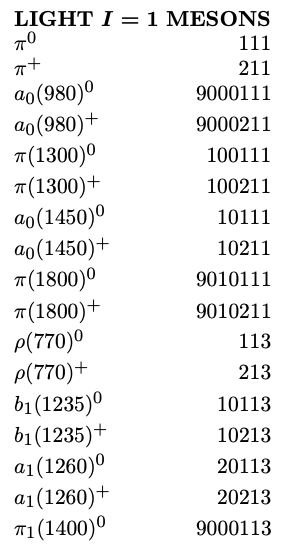 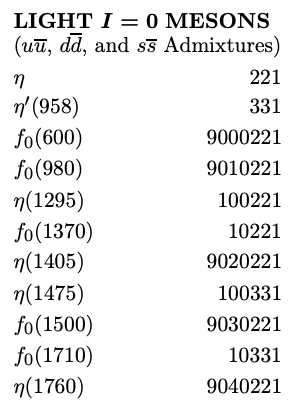 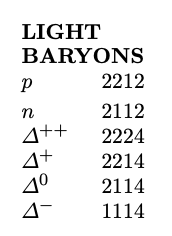

In [ ]:
from particle import Particle 

# https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf

event_df['name'] = event_df['pid'].apply(Particle.from_pdgid) #event['pid'].apply(PDG)
event_df

what kind of stable particles did Pythia generate?

In [ ]:
set(event_df['name'])   # selects unique values

You can also get information about the particles from the particle data group (PDG) website:


In [ ]:
from particle import PDGID

proton = PDGID(2212) 
print(proton.info())

In [ ]:
from BSMhighPT2023.utils import PDG_Info

PDG_Info(2212)

### Particle "Clouds"

Events at Hadron colliders are messy, even if the hard process has clean final states...

In [ ]:
from BSMhighPT2023.plotting import event_display_grid

event_display_grid(events[4:13], nrows=3, ncols=3, point_sizes=(2,200), lw=0, figsize=(12,12), grid=True)
        

## 4. Example (cont): SM Drell-Yan production $pp\to \mu^+\mu^-$

In [ ]:
multiplicity = [len(ev) for ev in events]   # we can use list comprehension to access some of the simpler event distributions

In [ ]:
# histogram for multiplicity

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(multiplicity, bins=25, range=(0, 1000), histtype='step', color='black', lw=0.75)
ax.set_xlabel('multiplicity')
ax.set_ylabel('counts')
plt.show()

For more involved selections and cuts use *boolean masks*:

In [ ]:
# select the two muons in the event:

muons = []

for event in events:
    
    mask = abs(event['pid']) == 13  # Boolean: True / False if the particle is a muon or not
    mus = event[mask]               # apply mask to get muons only
    muons.append(mus)

pd.DataFrame(muons[0])

# Task 2

Compute and get histograms for the following distributions:
- the difference in transverse momentum distribution $\Delta p_T = p_{T_{\mu_1}}-p_{T_{\mu_2}}$.
- the pseudorapidity differnce of the dimuons $\Delta{\eta}=\eta_{\mu_1}-\eta_{\mu_2}$.
- the azimuthal angle differnce of the dimuons $\Delta{\phi}=\phi_{\mu_1}-\phi_{\mu_2}$.
- the plane distance between muons $\Delta R=\sqrt{\Delta\eta^2 +\Delta\phi^2}$
- the dimuon invariant mass distribution $m_{\mu\mu}$.